In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from corner import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2022-07-07 11:33:53.626130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 11:33:53.626151: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi) 
        * x**slope * (slope+1) 
        / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    return (
        np.random.uniform(size=n_samples) * (hi**(slope+1) - lo**(slope+1))
        + lo**(slope+1)
        )**(1/(slope+1))

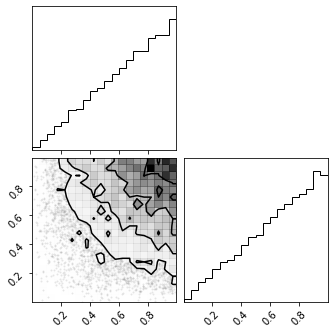

In [3]:
n_dim = 2
n_samples = 10000
slope = 1
lo = 0
hi = 1

data = sample_powerlaw([n_samples, n_dim], 1, 0, 1)

corner(data);

In [4]:
def all_permuted(n_dim):
    
    permutations = np.array(list(itertools.permutations(range(n_dim))))
    permuted = ~np.any(permutations == list(range(n_dim)), axis=1)
    
    return permutations[permuted]

In [5]:
permutations = all_permuted(n_dim)
permutations

array([[1, 0]])

In [6]:
n_flows = 10
n_layers = 1
n_neurons = 1024

# The function u = f(x), where x is the data and u is the base variate
bijectors = []

# We transform at the end with a logistic function
# This ensures all samples are in [0, 1]
bijectors.append(tfb.Scale(scale=.5))
bijectors.append(tfb.Shift(shift=1.))
bijectors.append(tfb.Tanh())

for i in range(n_flows):
    bijectors.append(tfb.MaskedAutoregressiveFlow(tfb.AutoregressiveNetwork(
        params=2,
        hidden_units=[n_neurons]*n_layers,
        activation='relu',
        ))
        )
    #bijectors.append(tfb.BatchNormalization(training=True))
    bijectors.append(tfb.Permute(list(reversed(range(n_dim)))))

bijector = tfb.Chain(bijectors)
distribution = tfd.MultivariateNormalDiag(loc=[0]*n_dim)
nf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)

2022-07-07 11:33:57.356887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-07 11:33:57.356930: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-07 11:33:57.356949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phy-190401): /proc/driver/nvidia/version does not exist
2022-07-07 11:33:57.357268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Check it's bounded
nf.sample(10000).numpy().min(), nf.sample(10000).numpy().max()

(0.0007175207, 0.9995234)

In [8]:
epochs = 10
batch_size = 100
learning_rate = 1e-3

x = tf.keras.Input(shape=[n_dim], dtype=tf.float32)
log_prob = nf.log_prob(x)

model = tf.keras.Model(
    inputs=x,
    outputs=log_prob,
    )

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=lambda _, log_prob: -log_prob,
    )

steps_per_epoch = n_samples // batch_size

result = model.fit(
    x=data, y=np.zeros(n_samples),
    epochs=epochs, 
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    shuffle=True,
    verbose=1,
    )

Epoch 1/10
100/100 [==============================] - 5s 17ms/step - loss: -0.3363
Epoch 2/10
100/100 [==============================] - 2s 16ms/step - loss: -0.3595
Epoch 3/10
100/100 [==============================] - 2s 15ms/step - loss: -0.3535
Epoch 4/10
100/100 [==============================] - 1s 13ms/step - loss: -0.3607
Epoch 5/10
100/100 [==============================] - 1s 13ms/step - loss: -0.3600
Epoch 6/10
100/100 [==============================] - 1s 14ms/step - loss: -0.3600
Epoch 7/10
100/100 [==============================] - 2s 17ms/step - loss: -0.3690
Epoch 8/10
100/100 [==============================] - 1s 15ms/step - loss: -0.3689
Epoch 9/10
100/100 [==============================] - 2s 15ms/step - loss: -0.3672
Epoch 10/10
100/100 [==============================] - 2s 15ms/step - loss: -0.3687


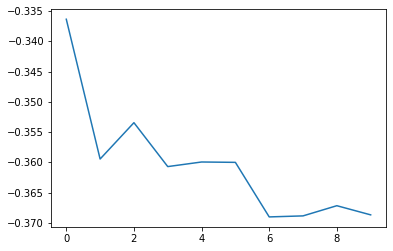

In [9]:
plt.plot(result.history['loss']);

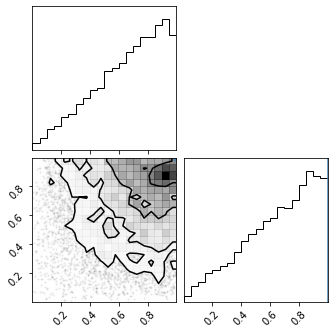

In [12]:
# Should be like the training data
corner(nf.sample(n_samples).numpy(), truths=[1]*n_dim);

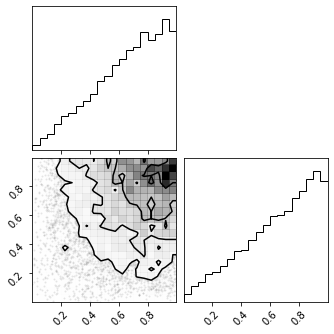

In [14]:
# Can I call bijector directly?
corner(
    nf.bijector.forward(distribution.sample(10000)).numpy(),
    );

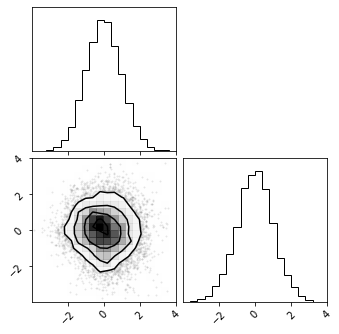

In [16]:
# Should be a Gaussian
fig = corner(
    nf.bijector.inverse(
        sample_powerlaw([n_samples, n_dim], slope, lo, hi).astype(np.float32),
        ).numpy(),
    range=[[-4, 4]]*n_dim,
    );

2022-07-07 11:35:08.541107: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163840000 exceeds 10% of free system memory.
2022-07-07 11:35:08.593627: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163840000 exceeds 10% of free system memory.
2022-07-07 11:35:08.668805: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163840000 exceeds 10% of free system memory.
2022-07-07 11:35:08.775661: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163840000 exceeds 10% of free system memory.
2022-07-07 11:35:08.830553: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163840000 exceeds 10% of free system memory.


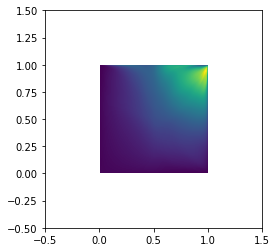

In [17]:
if n_dim == 1:
    
    points = np.linspace(0, 1, 200)
    probs = np.exp(nf.log_prob(points[:, None]))
    
    plt.plot(points, powerlaw(points, slope, lo, hi))
    plt.plot(points, probs);

elif n_dim == 2:

    points = np.linspace(-.5, 1.5, 200)
    axes = np.meshgrid(*[points]*n_dim)
    grid = np.concatenate([ax.reshape(-1, 1) for ax in axes], axis=1)

    probs = np.exp(nf.log_prob(grid)).reshape(axes[0].shape)

    plt.imshow(
        probs,
        aspect='equal',
        origin='lower',
        extent=[-.5, 1.5, -.5, 1.5],
        );